In [1]:
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
block_path = '/home/AD/tsheehan/data/Pen01_Lft_AP750_ML1750__Site01_Z1100__B952_cat_P01_S01_1'
from ephys import core
from ephys import clust
from ephys import events
from ephys import rasters
import os
import scipy as sp
import scipy.io.wavfile as wf
import scipy.signal as signal
import get_STA

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
# want to get STA and STC for example dataset
# load response (neurons), stimulus (wav files to spectrograms)
clusters = core.load_clusters(block_path) # pandas - DataFrame
neurons = (
    clusters[clusters.quality.isin(['Good'])]
    .sort_values(['quality','cluster'],ascending=False)
    .reset_index()
)
trials = events.load_trials(block_path)
stim_labels = list(set(trials.stimulus))
spikes = core.load_spikes(block_path)

fs = 44100
stim_labels[0]
stim_loc = block_path + '/stims'
files = os.listdir(stim_loc)
songs = []
spects = []
freqs = []
times = []
noverlap = 512
nperseg = 1024

for i in range(len(stim_labels)):
    this_label = stim_labels[i] +'.wav'
    my_song = [x for x in files if x in this_label]
    if my_song:
        this_song = wf.read(stim_loc + '/' + my_song[0])
        songs.append((this_song[1]))    
    
    #my_spect = signal.spectrogram(songs[i],fs =fs, nperseg = nperseg,noverlap = noverlap)
    #spects.append(my_spect[2])
    #freqs.append(my_spect[0])
    #times.append(my_spect[1])

# Spike Triggered Averages

In [4]:
#reload(get_STA)
song_names = list(set(trials['stimulus']))
ratio = get_STA.get_ds_rate(songs)
song_mask, song_ramp = get_STA.get_song_mask(trials,ratio/2)

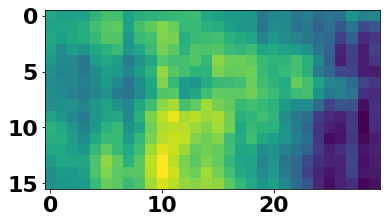

In [50]:
neuron_ind = 2
window = 30
my_cluster = neurons['cluster'][neuron_ind]
my_spikes = spikes[spikes['cluster']==my_cluster]
spk_times = my_spikes['time_samples'].values
STA,f = get_STA.get_sta(spk_times,songs,song_mask,song_ramp,window)
mSTA = np.mean(STA,0)
plt.imshow(mSTA)
plt.show()

# Spike Triggered Averages

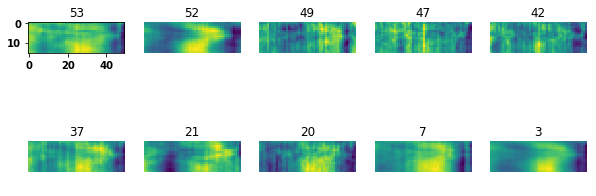

In [17]:
get_STA.visualize_some_stas(neurons,spikes,songs,song_mask,song_ramp,window)

# Decorrelated STA: (S*S^T)^-1* (STA)

In [55]:
# get covariance matrix
from scipy.linalg import inv
stack_out = get_STA.flat_reduced_spectrograms_ms(songs,window)
t_0 = np.shape(stack_out)[1]

my_covm = np.matmul(stack_out,np.transpose(stack_out))/t_0
my_cov_inv = inv(my_covm)
dSTA = np.reshape(np.matmul(my_cov_inv,mSTA.flatten()),np.shape(mSTA))

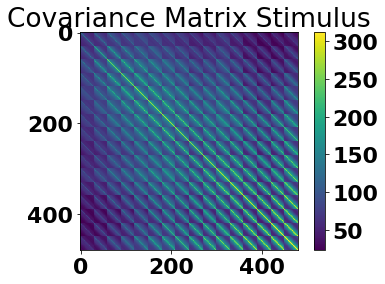

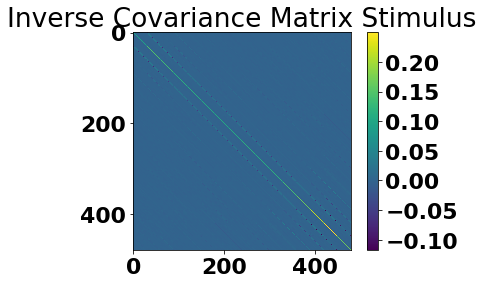

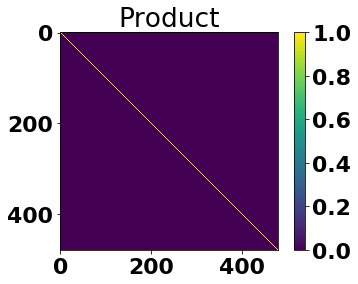

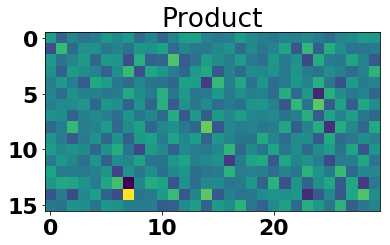

In [57]:
plt.imshow(my_covm)
plt.colorbar()
plt.title('Covariance Matrix Stimulus')
plt.show()

plt.imshow(my_cov_inv)
plt.colorbar()
plt.title('Inverse Covariance Matrix Stimulus')
plt.show()

plt.imshow(np.matmul(my_cov_inv,my_covm))
plt.colorbar()
plt.title('Product')
plt.show()

plt.imshow(dSTA)
# plt.colorbar()
plt.title('Product')
plt.show()

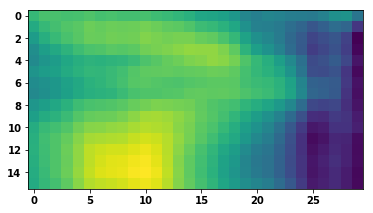

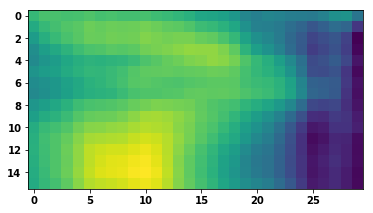

In [61]:
# Wrong ^ need to do only on elements with spikes
# first lest test our reshapping ability
mSTA = np.mean(STA,0)
mSTA_flat = mSTA.flatten()
mSTA_back = np.reshape(mSTA_flat,np.shape(mSTA))
plt.imshow(mSTA)
plt.show()
plt.imshow(mSTA_back)
plt.show()

# Failed Matrix Inversion...

In [23]:
# flatten each instance
STA_stack_flat = np.reshape(STA,(np.size(STA,0),np.size(mSTA)))
n_spk = np.size(STA,0)
this_cov = np.matmul(np.transpose(STA_stack_flat),STA_stack_flat)/n_spk
np.shape(STA_stack_flat)
this_cov2 = np.cov(STA_stack_flat,rowvar=False)

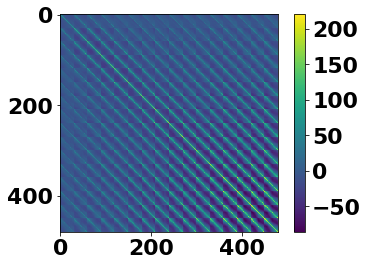

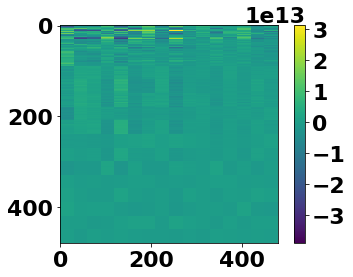

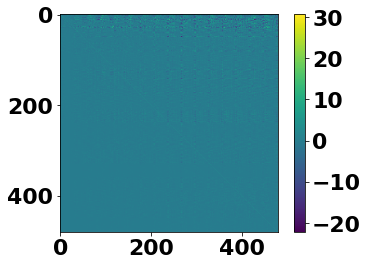

In [22]:
this_covi = inv(this_cov2)

plt.imshow(this_cov2)
plt.colorbar()
plt.show()

plt.imshow(this_covi)
plt.colorbar()
np.shape(this_covi)
plt.show()

plt.imshow(np.matmul(this_covi,this_cov2))
plt.colorbar()
np.shape(this_covi)
plt.show()

# Try MNE Code

In [24]:
import theano
import mner.optimizer
import mner.util.util
import mner.solvers.solvers
import mner.solvers.constraints
import mner.solvers.samplers

In [51]:
my_cluster = neurons['cluster'][neuron_ind]
my_spikes = spikes[spikes['cluster']==my_cluster]
spk_times = my_spikes['time_samples'].values

song_use = 0
PSTH = get_STA.get_PSTH(spk_times,song_use,song_mask,song_ramp)

window = 30
quick_spect = get_STA.flat_reduced_spectrogram(songs[song_use],window)
print(np.shape(PSTH),np.shape(quick_spect))
quick_spectT = np.transpose(quick_spect)

s, s_avg, s_std = mner.util.util.zscore_features(quick_spectT)
y = PSTH[window-1:]

jack = 1
njack = 4

3227
((3227,), (480, 3198))


In [52]:
# fraction of the data reserved for training and cross-validation (remainder is testing)
train_fraction = 0.7
cv_fraction = 0.2
nsamp = np.shape(s)[0]
ndim = np.shape(s)[1]
# print(np.shape(s),ndim)

trainset, cvset, testset, nshift = mner.util.util.generate_dataset_logical_indices(train_fraction, cv_fraction, nsamp, njack)
trainset, cvset, testset = mner.util.util.roll_dataset_logical_indices(trainset, cvset, testset, nshift, jack-1)
datasets = {'trainset': trainset, 'cvset': cvset, 'testset': testset}

# model parameters
rank = 6
cetype = ["UV-linear-insert"]
rtype = ["nuclear-norm"]

# if J is symmetrized using linear constraints, need to set signs of eigenvalues
csigns = np.array([1, -1]*(rank/2))

# set scaling of cost function (for each data set)
fscale = {"trainset": -1, "cvset": -1, "testset": -1}

# choose solver
#solver = mner.solvers.solvers.IPMSolver
solver = mner.solvers.solvers.LBFGSSolver

# fit parameters (note the change for demo_type == 7 below)
factr = 1.0e10
lbfgs = 30

In [53]:
opt = mner.optimizer.Optimizer(y, s, rank, cetype=cetype, rtype=[], solver=solver, datasets=datasets, fscale=fscale, csigns=csigns, lbfgs=lbfgs, precompile=True, compute_hess=False, verbosity=2, iprint=1, factr=factr)
x, ftrain = opt.optimize()

a, h, U, V = mner.util.util.vec_to_weights(x, ndim, rank)
V = np.dot(U, np.diag(csigns))
# form J and symmetrize then compute components
Jsym = np.dot(U, V.T)
Jsym = 0.5*(Jsym + Jsym.T) # covariance matrix of Jsym
[u, _, _] = np.linalg.svd(Jsym)

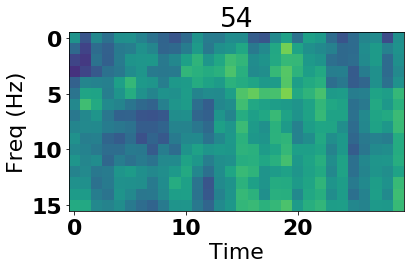

In [63]:
nx = window
ny = 16
cm = .2
plt.imshow(np.reshape(u[:,1], (ny, nx)), aspect='equal', interpolation='none',clim=(-cm, cm))
plt.title(my_cluster)
plt.xlabel('Time')
plt.ylabel('Freq (Hz)')
# plt.colorbar()
plt.show()

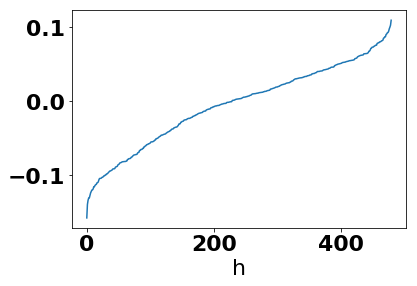

In [67]:
plt.plot(np.sort(h))
plt.xlabel('h')


In [71]:
np.shape(Jsym)

(480, 480)

In [72]:
a

array([-0.68168658])